# Dataset Problem Analysis

**Goal:** diagnose root causes of poor model performance (e.g., "garbage in, garbage out") before tweaking hyperparameters.

## Phase 1: Verify Data Integrity
We need to check:
1.  **File Loading:** Can we load the raw data correctly?
2.  **Missing Values:** Are there NaNs that need handling?
3.  **Duplicates:** Are there duplicate rows inflating performance?
4.  **Target Distribution:** Is the label correct (0/1) and what is the imbalance?
5.  **Scale:** Do features have wildly different ranges?

Checking for file at: C:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\raw\creditcard.csv
SUCCESS: Data loaded. Shape: (284807, 31)
Total Missing Values: 0
Duplicate Rows: 1081 (0.38%)
Target Column identified: 'Class'
Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud Ratio: 0.1727%


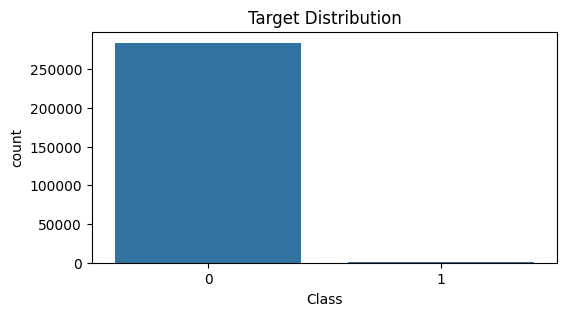


Feature Statistics (Amount vs Time vs V-features):
            min            max          mean           std
Time   0.000000  172792.000000  9.481386e+04  47488.145955
V1   -56.407510       2.454930  1.175161e-15      1.958696
V2   -72.715728      22.057729  3.384974e-16      1.651309
V3   -48.325589       9.382558 -1.379537e-15      1.516255
V4    -5.683171      16.875344  2.094852e-15      1.415869


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup Paths
DATA_DIR = Path('../data/raw')
# Using the new larger dataset
FILE_PATH = DATA_DIR / 'creditcard.csv' 

print(f"Checking for file at: {FILE_PATH.resolve()}")

if not FILE_PATH.exists():
    print("ERROR: File not found. Listing directory content:")
    # List dir to help debug path issues
    for f in DATA_DIR.glob('*'):
        print(f" - {f.name}")
else:
    # Load Data
    try:
        df = pd.read_csv(FILE_PATH)
        print(f"SUCCESS: Data loaded. Shape: {df.shape}")
        
        # 1. Missing Values
        missing = df.isnull().sum().sum()
        print(f"Total Missing Values: {missing}")
        if missing > 0:
             print(df.isnull().sum()[df.isnull().sum() > 0])
        
        # 2. Duplicates
        dupes = df.duplicated().sum()
        print(f"Duplicate Rows: {dupes} ({dupes/len(df):.2%})")
        
        # 3. Class Imbalance (Robust Detection)
        possible_targets = ['is_fraud', 'IsFraud', 'Class', 'target', 'fraud']
        target_col = next((col for col in possible_targets if col in df.columns), None)
        
        if not target_col:
             print(f"ERROR: Target column not found. Columns: {df.columns.tolist()}")
        else:
             print(f"Target Column identified: '{target_col}'")
             counts = df[target_col].value_counts()
             print(f"Class Distribution:\n{counts}")
             print(f"Fraud Ratio: {counts.get(1, 0) / len(df):.4%}")
             
             plt.figure(figsize=(6,3))
             sns.countplot(x=target_col, data=df)
             plt.title("Target Distribution")
             plt.show()

        # 4. Feature Stats (Checking for scaling issues)
        print("\nFeature Statistics (Amount vs Time vs V-features):")
        # Filter numeric only for describe to avoid errors if non-numeric cols exist
        print(df.describe().T[['min', 'max', 'mean', 'std']].head())
        
    except Exception as e:
        print(f"CRITICAL ERROR Loading Data: {e}")

## Phase 2: Test with Known-Good Baseline

We will run a simple **Random Forest** on a small subset of the data. 
**Why?** Random Forests are robust to unscaled data and outliers. If a Random Forest gets AUC < 0.6, the problem is likely **missing signal** (features don't predict target) rather than modeling technique.

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

def run_baseline_check(df, target_col):
    # Sample for speed (stratified)
    sample_size = min(20000, len(df))
    
    try:
        # Prepare X, y
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        # Handle Categorical Columns if any (simple encoding)
        for col in X.select_dtypes(include=['object']).columns:
            print(f"Encoding categorical column: {col}")
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            
        # Stratified Sample
        X_sample, _, y_sample, _ = train_test_split(
            X, y, train_size=sample_size, stratify=y, random_state=42
        )
        
        print(f"\nRunning Baseline RF on {len(X_sample)} samples...")
        
        # Model: Simple RF
        rf = RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42)
        
        # CV Score
        cv_scores = cross_val_score(rf, X_sample, y_sample, cv=5, scoring='roc_auc')
        print(f"5-Fold CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        if cv_scores.mean() < 0.7:
            print("\n[WARNING] Baseline Performance is POOR (AUC < 0.7).")
            print("Potential Issues: Noisy labels, non-predictive features, or severe data corruption.")
        else:
             print("\n[PASS] Baseline Performance is GOOD. Signal exists in the data.")

        # Feature Importance Check
        rf.fit(X_sample, y_sample)
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        print("\nTop 5 Predictive Features:")
        print(importances.head())
        
    except Exception as e:
        print(f"Error running baseline: {e}")

# Execute if df exists from Phase 1
if 'df' in locals():
    possible_targets = ['is_fraud', 'IsFraud', 'Class', 'target', 'fraud']
    target = next((col for col in possible_targets if col in df.columns), None)
    
    if target:
        run_baseline_check(df, target)
    else:
        print("ERROR: Could not find target column automatically during Phase 2.")
else:
    print("Dataframe 'df' not found. Please fix Phase 1 first.")


Running Baseline RF on 20000 samples...
5-Fold CV ROC-AUC: 0.9707 (+/- 0.0707)

[PASS] Baseline Performance is GOOD. Signal exists in the data.

Top 5 Predictive Features:
V14    0.217688
V10    0.205385
V17    0.090192
V12    0.073204
V4     0.066261
dtype: float64
